For this homework, you will implement a few different heuristics to solve the vehicle routing problem with time windows. Please answer the following questions at the end of this document.

For this homework, you will need the following files that were distributed along with this Jupyter notebook.
- routing.py
- data.dat

# Introduction

Import packages.

In [1]:
import math
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import time

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from collections import defaultdict
import heapq
from sklearn.cluster import KMeans

import routing
from routing import VRPInstance, TSPInstance, VRPModel, TSPModel

Create data structures for the dataset you will use for this homework.

In [2]:
numb_customers = 100
data_df = pd.read_csv('data.dat', sep='\s+')
data_dict_rows = data_df.to_dict(orient='records')
locations = {row['CUST_NO'] : row for row in data_dict_rows if row['CUST_NO'] <= numb_customers}
depot = 1
cost_per_mile = 1
avg_speed = 1 # miles per hour
n = len(locations)

Show the locations of customers that must be visited.

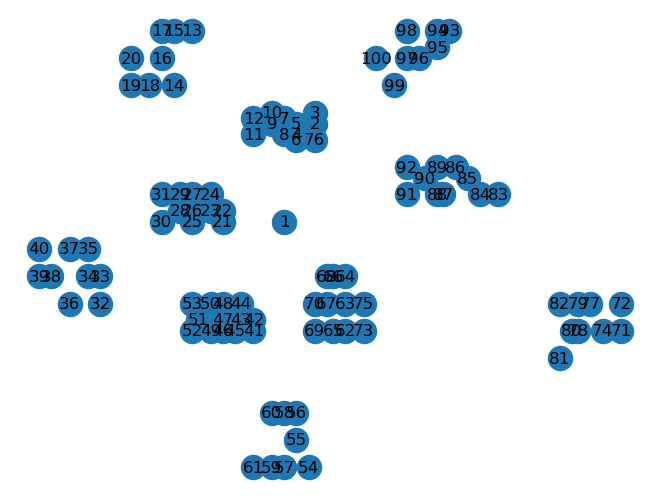

In [3]:
routing.show_tours([], locations, to_tikz=True, tikz_file_name='customers.tex')

Create dictionaries to hold problem data.

In [4]:
nodes = list(locations.keys())
edges = [(i,j) for i in nodes for j in nodes if i != j]
dist = {}
edge_costs = {}
travel_time = {}
for i in nodes:
    for j in nodes:
        x = routing.get_coordinate(locations, i)
        y = routing.get_coordinate(locations, j)
        dist[(i, j)] = routing.euclidean_distance(x, y)
        edge_costs[(i, j)] = routing.get_cost(x, y, cost_per_mile)
        travel_time[(i, j)] = routing.get_time(x, y, avg_speed)

# VRP with Time Windows (VRPTW)

In [5]:
num_vehicles  = 10
vrp_instance = VRPInstance(data_file = 'data.dat', 
                    num_customers = 100,
                    num_vehicles = num_vehicles, 
                    depot = 1, 
                    vehicle_capacity = 200,
                    average_speed=1,
                    cost_per_mile=1)
vrptw = VRPModel(vrp_instance)
m = vrptw.get_gurobipy_model()
m.write("vrptw.lp")
routing.solve_model(m)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-05
Optimal objective value: 825
Optimization time: 4.818 seconds


In [6]:
vrptw.print_solution_from_model(m)

vehicle 0
tour [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 2, 76, 1]
Node 1 visited at time 0.0 window 0.0 1236.0
Node 6 visited at time 15.13274595036637 window 15.0 67.0
Node 4 visited at time 106.13274595036637 window 65.0 146.0
Node 8 visited at time 198.1327459503664 window 170.0 225.0
Node 9 visited at time 290.96117307513487 window 255.0 324.0
Node 11 visited at time 384.5667243505595 window 357.0 410.0
Node 12 visited at time 498.7600351093556 window 448.0 505.0
Node 10 visited at time 591.9223127695718 window 534.0 605.0
Node 7 visited at time 684.1583807470729 window 621.0 702.0
Node 5 visited at time 776.394448724574 window 727.0 782.0
Node 2 visited at time 967.0 window 912.0 967.0
Node 76 visited at time 1068.0 window 997.0 1068.0
return time 1174.0
vehicle 1
tour [1, 14, 18, 19, 20, 16, 17, 15, 13, 1]
Node 1 visited at time 0.0 window 0.0 1236.0
Node 14 visited at time 30.80584360146895 window 30.0 92.0
Node 18 visited at time 124.80584360146895 window 99.0 148.0
Node 19 visited at

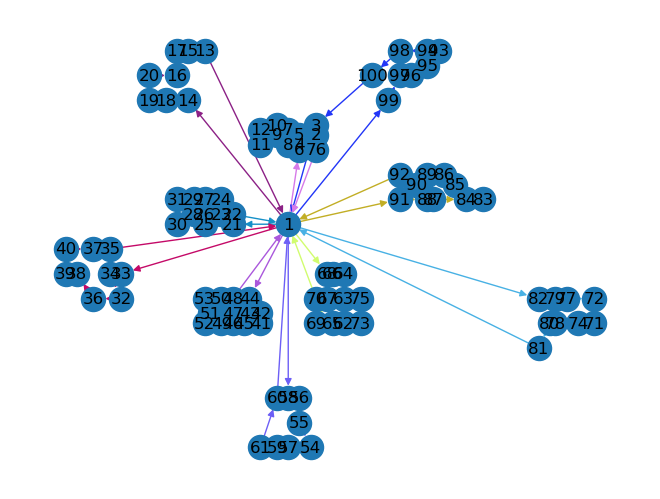

In [7]:
routing.show_tours(vrptw.get_edges_used_for_vehicles(m), vrp_instance.locations, to_tikz = True,
                   num_vehicles = num_vehicles,
                   tikz_file_name = "vrptw.tex")

# VRPTW: Relaxation

The following code finds a solution to the LP relaxation of a VRPTW formulation. Can we round this solution to obtain a feasible one?

In [8]:
vrptw = VRPModel(vrp_instance)
m = vrptw.get_gurobipy_model(relaxed = True)
routing.solve_model(m)

Optimal objective value: 542
Optimization time: 0.392 seconds


In [9]:
for k in vrp_instance.vehicles:
    print("vehicle", k)
    edges_used_adjacency_list= {i : {j : m._x[i, j,k].x for j in vrp_instance.nodes} for i in vrp_instance.nodes}
    for i in edges_used_adjacency_list:
        for j in edges_used_adjacency_list[i]:
            if edges_used_adjacency_list[i][j] > 0.01:
                print((i,j), edges_used_adjacency_list[i][j])

vehicle 0
(1, 22) 1.0
(14, 18) 0.9996126148351929
(16, 14) 0.9996126148351929
(18, 19) 0.9996126148351929
(19, 20) 0.9996126148351929
(20, 16) 0.9996126148351929
(22, 1) 1.0
(54, 57) 0.79966397712415
(57, 54) 0.79966397712415
(93, 94) 0.33438812272615503
(94, 93) 0.33438812272615503
vehicle 1
(1, 64) 0.9998093944487245
(11, 12) 0.9998159999999999
(12, 11) 0.999816
(38, 40) 0.9998119999999999
(39, 38) 0.999812
(40, 39) 0.9998119999999999
(54, 57) 0.20033602287584995
(57, 54) 0.20033602287584995
(64, 1) 0.9998093944487245
(85, 86) 0.9998101715728752
(86, 85) 0.9998101715728752
vehicle 2
(1, 76) 0.9998093944487245
(76, 1) 0.9998093944487245
vehicle 3
(1, 24) 1.0
(24, 1) 1.0
(58, 60) 0.999344
(60, 58) 0.999344
(63, 75) 0.9998159999999999
(75, 63) 0.999816
(93, 94) 0.33190035824896424
(94, 93) 0.33190035824896424
(95, 98) 0.5032003640143741
(98, 95) 0.5032003640143741
vehicle 4
(1, 68) 1.0
(9, 10) 0.999629
(10, 9) 0.999629
(13, 17) 0.999728
(15, 13) 0.999728
(17, 15) 0.999728
(43, 45) 0.999

# Problem 1: Round the solution to the Relaxed VRPTW model

Do the following:
- a. Describe an algorithm for rounding the LP relaxation solution to the VRPTW problem.
- b. Implement your algorithm in code.
- c. Verify that the solution computed by your algorithm is feasible.
- d. Compare the total cost of your solution with the optimal solution computed by Gurobi (see above).
- e. Report the runtime of your algorithm.

 # Problem 1 Solution

Approach:
1. Cluster customers using K-Means with Euclidean distance metric.
2. Check to make sure that for each cluster, the total demand is no more than vehicle capacity.
3. Assign a vehicle to each cluster.
4. Use a variant of `round_tsp_solution` to find a tour for each vehicle.

Step 1: K-Means based on $(x,y)$ coordinates and Euclidean distance.

In [10]:
customer_coor = {key: value for key, value in vrp_instance.coordinates.items() if key != depot}
clusters = routing.get_clusters(customer_coor, num_vehicles)

Step 2: Check that vehicle capacity constraints are not violated.

In [11]:
for k in vrp_instance.vehicles:
    print(k, vrptw.get_total_demand_for_vehicle(clusters, k), clusters[k])

0 200.0 [62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75]
1 170.0 [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
2 190.0 [13, 14, 15, 16, 17, 18, 19, 20]
3 170.0 [83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
4 180.0 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 76]
5 150.0 [71, 72, 74, 77, 78, 79, 80, 81, 82]
6 200.0 [54, 55, 56, 57, 58, 59, 60, 61]
7 200.0 [32, 33, 34, 35, 36, 37, 38, 39, 40]
8 160.0 [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
9 170.0 [93, 94, 95, 96, 97, 98, 99, 100]


Steps 3 and 4: Assign vehicles to cluster; use `nearest_neighbor_heuristic_time_windows_from_rounded` to find a tour for each vehicle. If you look at the implementation of this method, you will see that it choses the "nearest" neighbor based on three criteria: (1) distance, (2) midpoint of the time window, and (3) value of the variables in the rounded solution.

In [12]:
tsp_instance = routing.TSPInstance(data_file = 'data.dat', 
                    num_customers = 100,
                    average_speed=1,
                    cost_per_mile=1)
tsp = TSPModel(tsp_instance)

In [13]:
total_cost = 0
tours = {}
for k in vrp_instance.vehicles:
    edges_used_adjacency_list= {i : {j : m._x[i, j, k].x for j in nodes} for i in nodes}
    tours[k] = tsp.nearest_neighbor_heuristic_time_windows_from_rounded(vrp_instance.depot, 
                                edges_used_adjacency_list, [vrp_instance.depot] + clusters[k])
    total_cost += routing.get_cost_of_tour(tours[k], vrp_instance.edge_costs)
print("Total cost", total_cost)

current node 1 current time 0
1 feasible neighbors [62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75]
current node 68 current time 12.0 window [12.0, 77.0] on time True
68 feasible neighbors [62, 63, 64, 65, 66, 67, 69, 70, 73, 75]
current node 66 current time 76.0 window [76.0, 129.0] on time True
66 feasible neighbors [62, 63, 64, 65, 67, 69, 70, 73, 75]
current node 64 current time 171.0 window [171.0, 218.0] on time True
64 feasible neighbors [62, 63, 65, 67, 69, 70, 73, 75]
current node 63 current time 262.0 window [262.0, 317.0] on time True
63 feasible neighbors [62, 65, 67, 69, 70, 73, 75]
current node 75 current time 353.0 window [353.0, 412.0] on time True
75 feasible neighbors [62, 65, 67, 69, 70, 73]
current node 73 current time 450.0 window [450.0, 505.0] on time True
73 feasible neighbors [62, 65, 67, 69, 70]
current node 62 current time 531.0 window [531.0, 610.0] on time True
62 feasible neighbors [65, 67, 69, 70]
current node 65 current time 632.0 window [632.0, 693.0] on ti

Print the solution.

In [14]:
for k in vrp_instance.vehicles:
    print("Vehicle", k, "Cluster", clusters[k])
    print("Tour: ", tours[k])

Vehicle 0 Cluster [62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75]
Tour:  [1, 68, 66, 64, 63, 75, 73, 62, 65, 69, 67, 70, 1]
Vehicle 1 Cluster [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Tour:  [1, 21, 25, 26, 28, 30, 31, 29, 27, 24, 23, 22, 1]
Vehicle 2 Cluster [13, 14, 15, 16, 17, 18, 19, 20]
Tour:  [1, 14, 18, 19, 20, 16, 17, 15, 13, 1]
Vehicle 3 Cluster [83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
Tour:  [1, 91, 88, 87, 84, 83, 85, 86, 89, 90, 92, 1]
Vehicle 4 Cluster [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 76]
Tour:  [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 3, 2, 76, 1]
Vehicle 5 Cluster [71, 72, 74, 77, 78, 79, 80, 81, 82]
Tour:  [1, 82, 79, 77, 72, 71, 74, 78, 80, 81, 1]
Vehicle 6 Cluster [54, 55, 56, 57, 58, 59, 60, 61]
Tour:  [1, 58, 56, 55, 54, 57, 59, 61, 60, 1]
Vehicle 7 Cluster [32, 33, 34, 35, 36, 37, 38, 39, 40]
Tour:  [1, 33, 34, 32, 36, 38, 39, 40, 37, 35, 1]
Vehicle 8 Cluster [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Tour:  [1, 44, 43, 42, 41, 45, 47, 46, 49, 52, 51, 53, 50

<!-- A possible algorithm is the following:
1. Ensure that each arc is used by only one vehicle: `assign_arcs_to_vehicles`.
2. Assign customers to vehicles: `assign_customers_to_vehicles`.
3. For each vehicle, round the solution to obtain a feasible tour: `round_tsp_solution`. -->


Display the solution.

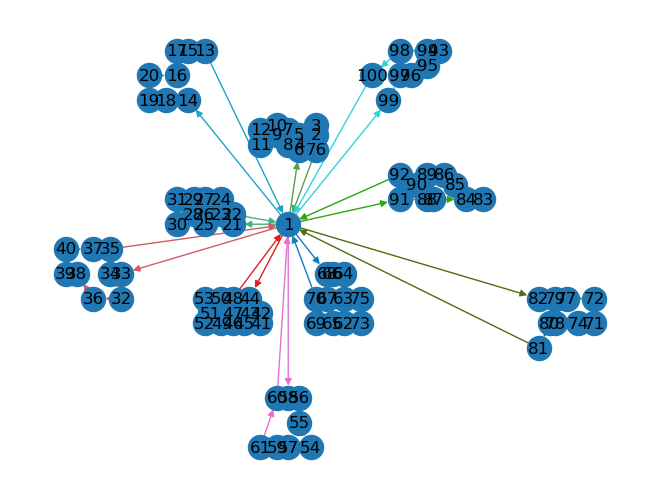

In [15]:
edges_used_for_vehicles = []
for k in vrp_instance.vehicles:
    edges_used_for_vehicles.append(routing.get_edges_used_from_tour(tours[k]))
routing.show_tours(edges_used_for_vehicles, vrp_instance.locations,
                   num_vehicles = num_vehicles)

<!-- Vehicle 3 cluster: 98 (1), 75 (7), 24 (9), 58 (4), 60 (4), 95 (1), 63 (7) -->

<!-- Notation:
- Let $u_{vc}$ be the utility obtained from assigning vehicle v to cluster $c$ (how many customers assigned to vehicle $v$ in fractional solution are in cluster $c$)
- Let $V$ be the set of vehicles
- Let $C$ be the set of clusters
- Let $x_{vc}$ be a variable that is 1 if vehicle $v$ is assigned to cluster $c$

$\max \sum_{v\in V}\sum_{c\in C} u_{vc}\,x_{vc}$

Subject to: $\sum_{v\in V} x_{vc} = 1\quad\forall c\in C$ -->

# Problem 2: Greedy Algorithm for VRPTW

Do the following:
- a. Describe a greedy algorithm for the VRPTW problem.
- b. Implement your algorithm in code.
- c. Verify that the solution computed by your algorithm is feasible.
- d. Compare the total cost of your solution with the optimal solution computed by Gurobi (see above).
- e. Report the runtime of your algorithm.

# Problem 2 Solution

Approach:
1. Cluster customers using K-Means with Euclidean distance metric.
2. Check to make sure that for each cluster, the total demand is no more than vehicle capacity.
3. Assign a vehicle to each cluster.
4. Use greedy or nearest neighbor algorithm to find the route for each vehicle.

Step 1: K-Means based on $(x,y)$ coordinates and Euclidean distance.

In [16]:
customer_coor = {key: value for key, value in vrp_instance.coordinates.items() if key != depot}
clusters = routing.get_clusters(customer_coor, num_vehicles)

Step 2: Check that vehicle capacity constraints are not violated.

In [17]:
for k in vrp_instance.vehicles:
    print(k, vrptw.get_total_demand_for_vehicle(clusters, k), clusters[k])

0 170.0 [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
1 170.0 [83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
2 150.0 [71, 72, 74, 77, 78, 79, 80, 81, 82]
3 200.0 [54, 55, 56, 57, 58, 59, 60, 61]
4 180.0 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 76]
5 200.0 [32, 33, 34, 35, 36, 37, 38, 39, 40]
6 160.0 [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
7 200.0 [62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75]
8 190.0 [13, 14, 15, 16, 17, 18, 19, 20]
9 170.0 [93, 94, 95, 96, 97, 98, 99, 100]


Steps 3 and 4: Assign vehicless to cluster; use nearest neighbor heuristic to find tours for each vehicle.

In [18]:
total_cost = 0
tours = {}
for k in vrp_instance.vehicles:
    tours[k] = tsp.nearest_neighbor_heuristic_time_windows(vrp_instance.depot, [vrp_instance.depot] + clusters[k])
    total_cost += routing.get_cost_of_tour(tours[k], vrp_instance.edge_costs)
print("Total cost", total_cost)

current node 1 current time 0
current node 21 current time 10.0 window [10.0, 73.0] on time True
current node 25 current time 65.0 window [65.0, 144.0] on time True
current node 26 current time 169.0 window [169.0, 224.0] on time True
current node 28 current time 261.0 window [261.0, 316.0] on time True
current node 30 current time 358.0 window [358.0, 405.0] on time True
current node 31 current time 449.0 window [449.0, 504.0] on time True
current node 29 current time 546.0 window [546.0, 593.0] on time True
current node 27 current time 622.0 window [622.0, 701.0] on time True
current node 24 current time 732.0 window [732.0, 777.0] on time True
current node 23 current time 812.0 window [812.0, 883.0] on time True
current node 22 current time 914.0 window [914.0, 965.0] on time True
current node 1 current time 0
current node 91 current time 20.0 window [20.0, 84.0] on time True
current node 88 current time 85.0 window [85.0, 144.0] on time True
current node 87 current time 173.0 windo

Print the solution

In [19]:
for k in vrp_instance.vehicles:
    print("Vehicle", k, "Cluster", clusters[k])
    print("Tour: ", tours[k])

Vehicle 0 Cluster [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Tour:  [1, 21, 25, 26, 28, 30, 31, 29, 27, 24, 23, 22, 1]
Vehicle 1 Cluster [83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
Tour:  [1, 91, 88, 87, 84, 83, 85, 86, 89, 90, 92, 1]
Vehicle 2 Cluster [71, 72, 74, 77, 78, 79, 80, 81, 82]
Tour:  [1, 82, 79, 77, 72, 71, 74, 78, 80, 81, 1]
Vehicle 3 Cluster [54, 55, 56, 57, 58, 59, 60, 61]
Tour:  [1, 58, 56, 55, 54, 57, 59, 61, 60, 1]
Vehicle 4 Cluster [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 76]
Tour:  [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 3, 2, 76, 1]
Vehicle 5 Cluster [32, 33, 34, 35, 36, 37, 38, 39, 40]
Tour:  [1, 33, 34, 32, 36, 38, 39, 40, 37, 35, 1]
Vehicle 6 Cluster [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Tour:  [1, 44, 43, 42, 41, 45, 47, 46, 49, 52, 51, 53, 50, 48, 1]
Vehicle 7 Cluster [62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75]
Tour:  [1, 68, 66, 64, 63, 75, 73, 62, 65, 69, 67, 70, 1]
Vehicle 8 Cluster [13, 14, 15, 16, 17, 18, 19, 20]
Tour:  [1, 14, 18, 19, 20, 16, 17, 15

Display the solution.

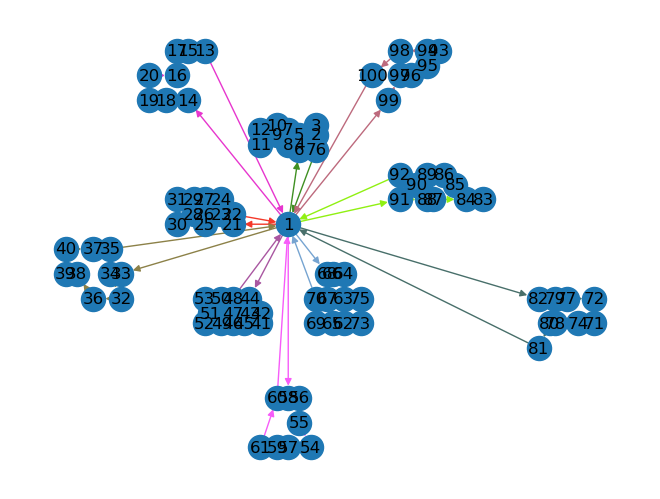

In [20]:
edges_used_for_vehicles = []
for k in vrp_instance.vehicles:
    edges_used_for_vehicles.append(routing.get_edges_used_from_tour(tours[k]))
routing.show_tours(edges_used_for_vehicles, vrp_instance.locations,
                   num_vehicles = num_vehicles)

# Problem 3: Local Search for VRPTW

Do the following:
- a. Describe a local search algorithm for the VRPTW problem.
- b. Implement your algorithm in code.
- c. Use your algorithm to improve the rounded solution you obtained in Problem 1.
- c. Verify that the solution computed by your algorithm is feasible.
- d. Compare the total cost of your solution with the optimal solution computed by Gurobi (see above).
- e. Report the runtime of your algorithm.

# Problem 3: Solution

Approach:
Try to improve the greedy solution by iterating over all vehicles and trying swaps of cities within its tour. The method `get_improved_via_local_search` performs the local search.

In [21]:
total_cost = 0
for k in vrp_instance.vehicles:
    print("Vehicle", k, "Cluster", clusters[k])
    print("Tour: ", tours[k])
    improved_tour = tsp.get_improved_via_local_search(tours[k])
    print("Improved tour: ", improved_tour)
    total_cost += routing.get_cost_of_tour(improved_tour, vrp_instance.edge_costs)

Vehicle 0 Cluster [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Tour:  [1, 21, 25, 26, 28, 30, 31, 29, 27, 24, 23, 22, 1]
No improving solution found
Improved tour:  [1, 21, 25, 26, 28, 30, 31, 29, 27, 24, 23, 22, 1]
Vehicle 1 Cluster [83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
Tour:  [1, 91, 88, 87, 84, 83, 85, 86, 89, 90, 92, 1]
No improving solution found
Improved tour:  [1, 91, 88, 87, 84, 83, 85, 86, 89, 90, 92, 1]
Vehicle 2 Cluster [71, 72, 74, 77, 78, 79, 80, 81, 82]
Tour:  [1, 82, 79, 77, 72, 71, 74, 78, 80, 81, 1]
No improving solution found
Improved tour:  [1, 82, 79, 77, 72, 71, 74, 78, 80, 81, 1]
Vehicle 3 Cluster [54, 55, 56, 57, 58, 59, 60, 61]
Tour:  [1, 58, 56, 55, 54, 57, 59, 61, 60, 1]
No improving solution found
Improved tour:  [1, 58, 56, 55, 54, 57, 59, 61, 60, 1]
Vehicle 4 Cluster [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 76]
Tour:  [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 3, 2, 76, 1]
No improving solution found
Improved tour:  [1, 6, 4, 8, 9, 11, 12, 10, 7, 5, 3, 2, 76, 1]
Vehi

Because the greedy solution is very close to optimal, the local search does not improve it.

In [22]:
print("Total cost", total_cost)

Total cost 826
